In [11]:
import random
import datetime
import numpy as np
import h5py
from skimage.filters import threshold_otsu
from skimage import io
from matplotlib import pyplot as plt
import math
import tifffile
import os
import sys
import shutil
from skimage.draw import polygon as ski_polygon
import json

import openslide
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, create_tumor_mask, rgb2gray
from preprocessing.util import TileMap

import calculate_performance as calc

%matplotlib inline

In [12]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax #e to the x and divide by sum
import matplotlib.pyplot as plt
import time
from datetime import date
import os
import sys
import copy
from tqdm import tqdm
import shutil

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [14]:
def image_show(image, mymax, nrows=1, ncols=1, cmap='gray',size = 8):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size*image.shape[0]/image.shape[1]))
    try:
        mymax
        ax.imshow(image, vmax = mymax, cmap='gray')
    except NameError:
        ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [53]:
def copy_test_case_patches(test_path, test_case):  
    if os.path.exists(test_path) == False:
        os.mkdir(test_path)
        
    # Make folder to move all test patches to
    if os.path.exists(test_path + str(test_case)) == False:
        os.mkdir(test_path + '//' + str(test_case) + '//')
        os.mkdir(test_path +  '//' + str(test_case) + '//0//')
        os.mkdir(test_path +  '//' + str(test_case) + '//1//')
    print('created patch-based test folder in path: ' + str(test_path) + str(test_case) + '//')

    ## Copy test case 0 patches to the new folder
    for file in os.listdir('patches//0//'):
        if file.startswith(test_case):
            source = 'patches//0//' + file
            dest = test_path + str(test_case) + '//0//' + file
            print(source)
            print(dest)
            shutil.copy(source, dest) #move to designated path

    ## Copy test case 1 patches to the new folder
    for file in os.listdir('patches//1//'):
        if file.startswith(test_case):
            source = 'patches//1//' + file
            dest = test_path + str(test_case) + '//1//' + file
            shutil.copy(source, dest) #move to designated path

In [78]:
def create_dir(path): ## Creates directory if path doesn't exist
    if os.path.exists(path) == False:
        os.mkdir(path)

In [17]:
DIR = ''

mgr = SlideManager(cam16_dir=DIR)

slides_met = mgr.met_slides

N_met = len(slides_met)

slides_negative = mgr.negative_slides

N_negative = len(slides_negative)

level = 0

tile_size = 512 #must be the same as used for training

poi = 0.50 #must use the same poi we used to seperate tisse from background

overlap = tile_size // 2 #increasing overlap will put patches closer together

input_size = tile_size

In [32]:
data_dir = "test//"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Initialize directories and test images

In [80]:
## Copy test patches for each case to an isolated folder in the "test" directory.
## We will run the corresponding model on this directory when testing. 
## It is important NOT to contaminate each test directory with patches that the model was trained on
## For example, fold00_model.pt was trained on everything except case00 patches which are reserved for testing.

cases_to_test = ['case00']
for case in cases_to_test:
    if os.path.exists('test//' + str(case)) == False: ## If test patches do NOT exist,
        copy_test_case_patches('test//', case) ## then copy test patches to folder
        print('copying test patches for ' + str(case))

prediction_path = 'predictions//'
create_dir(prediction_path)

## Test each trained model on test patches and save ROC data

Making predictions for case00
Model name = fold00_model.pt


<IPython.core.display.Javascript object>


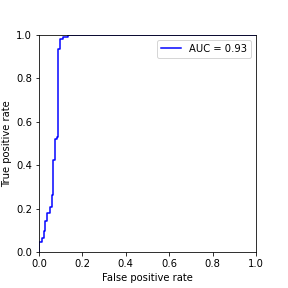

In [92]:
for case in cases_to_test:
    fold = int(case[-2:])
    patches_path = 'patches//'
    auc_all = []

    ## Initialize variables
    try:
        all_outputs
        del all_outputs
    except NameError:
        print('initializing variables')
    try:
        all_labels
        del all_labels
    except NameError:
        pass
    
    
    ## Load model
    model_name = 'fold' + str(fold).zfill(2) + '_model.pt'
    model = torch.load(model_name)
    model.eval()

    print('Making predictions for ' + str(case))
    print('Model name = ' + str(model_name))

    running_loss = 0.0
    running_corrects = 0
    n_classes = 2

    data_transforms = {
    case: transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    # Create dataloader
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [case]}
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in [case]}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in dataloaders_dict[case]: #get inputs. data is list of [inputs, labels]
        out = torchvision.utils.make_grid(inputs) #for visualizing inputs
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs) #output is not normalized
        #criterion function normalizes the outputs into probabilities with softmax
        loss = criterion(outputs, labels) #loss being nn.CrossEntropy
        _, preds = torch.max(outputs, 1) #prediction is given to maximum probability. i.e. threshold = 0.50

        labels_cpu = labels.cpu().detach().numpy()
        preds_cpu = preds.cpu().detach().numpy()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) #Number of corrects in each batch

        ## Store ALL labels and outputs for plot
        try:
            all_outputs
            all_outputs = np.append(all_outputs, outputs.cpu().detach().numpy(), axis = 0) 
            all_labels = np.append(all_labels, labels.cpu().detach().numpy(), axis = 0)
        except NameError:
            all_outputs = outputs.cpu().detach().numpy() #initial element of all_outputs
            all_labels = labels.cpu().detach().numpy() #initial element of all_outputs

    ## Get ROC curve for both test cases from this model
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    outputs_normalized = softmax(all_outputs, axis = 1)

    #create y_score (matrix of labels, 2 columns, 1 in column for positive class)
    y_score = np.zeros((len(all_labels),2))
    for col in range(len(all_labels)):
        y_score[col,all_labels[col]] = 1 #if labels_cpu[col] is 1, col 1 = 1
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_score[:,i], outputs_normalized[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])

    %matplotlib notebook
    plt.figure(figsize = (4,4))
    ax = plt.gca()
    ax.set_aspect(1)
    lw = 3
    font_size = 15
    plt.plot(fpr[1], tpr[1], 'b')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(['AUC = ' + str("{:.2f}".format(roc_auc[1]))])
    plt.show()
    
    # ## Save records of this test 
    np.save(prediction_path + str(case) + '_fpr.npy', fpr[1])
    np.save(prediction_path + str(case)  + '_tpr.npy', tpr[1])